# Random Matrix Model

Implementation of the Random Matrix (RM) algorithm according to section 3.1.

This notebooks contains a simple example, to which the RM algorithm will be applied. The example consists of a single stationary, rectangular object. Measurements are generated from the entire object surface.

The notebook aims to provide a simple overview. It is split into data generation and algorithm application.

In [1]:
# import packages
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
from scipy.linalg import sqrtm

# --- Matplotlib settings:
plt.rc('legend', fontsize=10, handlelength=2)  # legend size
plt.rc('font', size=12)  # fontsize

# colors:
c_gt = 'g'  # color for ground truth
c_meas = 'purple'  # color for measurements
c_est = 'b'  # color for estimates

---
## Data generation
The simple example used here is a stationary, rectangular object where measurements stem from the entire object surface.

In this part, data for this model will be generated and visualized.

First of all, the parameters for the object and measurements need to be set:

In [2]:
# --- object: 
object_center_x = 0
object_center_y = 0
object_length = 3  # x axis
object_width = 2 # y axis
# --- concatenate into a single variable x representing the true object location
gt_x = np.array([object_center_x, object_center_y, object_length, object_width])  # essentially an alias for the four parameters

# --- measurements:
# mean number of detections y from the object in each step 
lambda_y = 15
# each true measurement source y will be a 2D vector containing x- and y-position
# covariance of p(z|y) = N(z; y, R)
R = np.eye(2)*0.1 

# --- ensure format of parameters is correct
assert R.shape == (2,2), "R needs to be of shape (2,2)"

# --- set up global constants for implementation
N_STEPS = 10  # how many steps to run the simulation for
RNG = default_rng(42)  # numpy random generator 

---
Next, the corresponding measurements will be created, by first sampling a measurement source anywhere on the object surface and afterwards adding gaussian noise to generate the measurements passed to the Random Matrix algorithm.

In [3]:
def random_rect_surface(center_x, center_y, length, width, n_pts):
    """
    Given center, length and width of an axis-aligned rectangle, generate n_pts many points from its surface without noise.
    Creates two arrays of length n_pts: One with random x-coordinates in the rectangle, and a second one with random y-Coordinates.
    """
    xs = RNG.uniform(low=center_x - length / 2, high=center_x + length / 2, size=n_pts)
    ys = RNG.uniform(low=center_y - width / 2, high=center_y + width / 2, size=n_pts)
    return np.array(xs), np.array(ys)

# ---
# Use the above function to generate measurements:
# ---
    
y = []  # measurement sources
z_list = []  # received measurements
# use the above function to draw the corresponding measurements
for i in range(N_STEPS):
    n_measurements = RNG.poisson(lam=lambda_y)  # number of sources is poisson distributed with mean as specified above
    y_pos_x, y_pos_y = random_rect_surface(object_center_x, object_center_y, object_length, object_width, n_pts=n_measurements)  # get measurement source
    
    y_i = np.vstack([y_pos_x, y_pos_y]).T  #  current measurement sources to y, in shape (n_measurements, 2)
    y.append(y_i)
    # second: draw measurements z_i from y_i
    z_i = []
    for y_i_k in y_i:  # treat each measurement k = 0...n_measurements-1 independently
        z_i_k = RNG.multivariate_normal(mean=y_i_k, cov=R)  # p(z|y) = N(z; y, R)
        z_i.append(z_i_k)
    z_i = np.array(z_i)
    assert z_i.shape == y_i.shape, "Mismatch between z and y shape"
    z_list.append(z_i)
    
    print("Step: {}/{} - Number of Measurements generated: {}".format(i+1, N_STEPS, n_measurements))

Step: 1/10 - Number of Measurements generated: 18
Step: 2/10 - Number of Measurements generated: 12
Step: 3/10 - Number of Measurements generated: 13
Step: 4/10 - Number of Measurements generated: 21
Step: 5/10 - Number of Measurements generated: 7
Step: 6/10 - Number of Measurements generated: 15
Step: 7/10 - Number of Measurements generated: 14
Step: 8/10 - Number of Measurements generated: 19
Step: 9/10 - Number of Measurements generated: 15
Step: 10/10 - Number of Measurements generated: 17


---
#### Visualize Measurements

In order to visualize the measurement, it is first necessary to define some necessary functions for plotting.

Afterwards, each time step can be visualized individually.

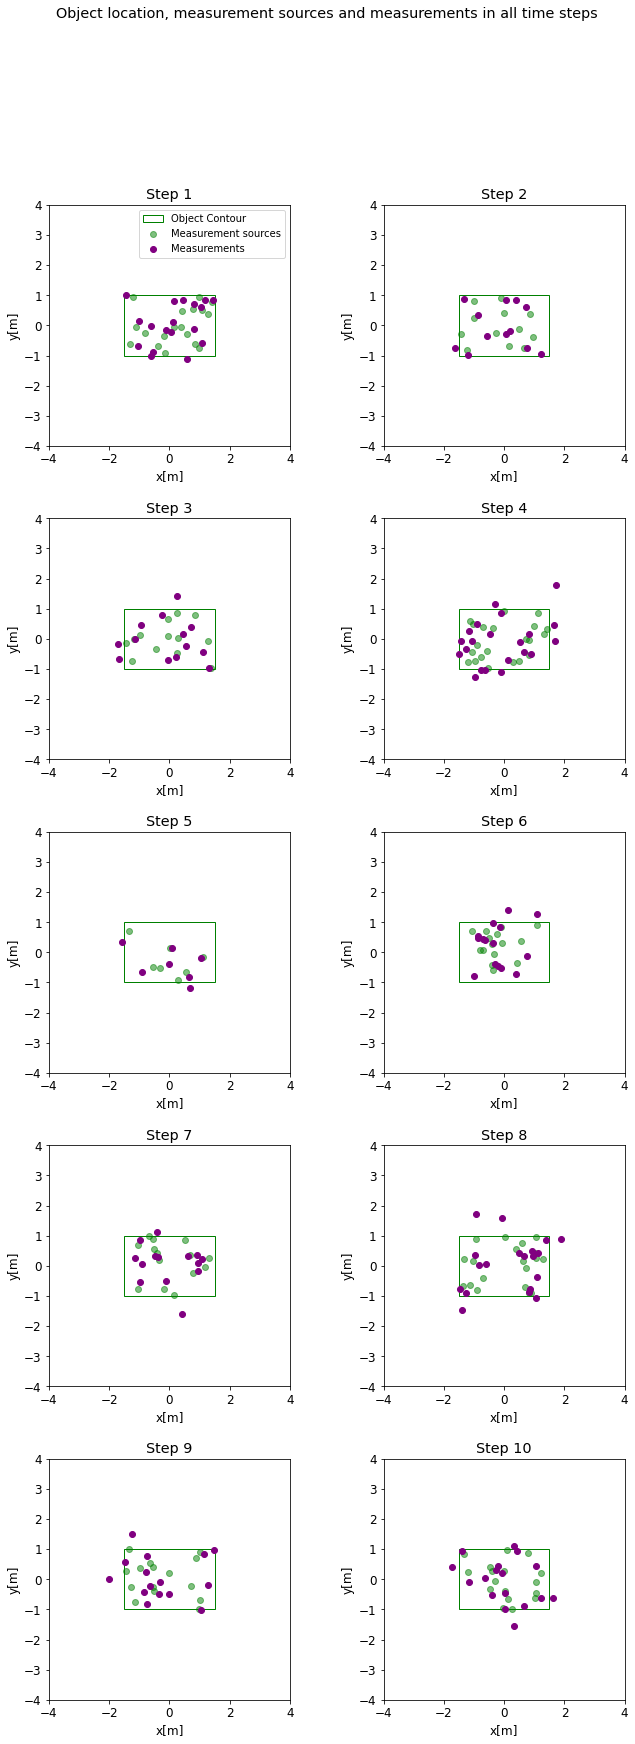

In [4]:
def plt_square(loc, l, ax=None, label_as_m=True):
    """
    Helper function to quickly focus a plot on a location loc with margins l to all sides.
    Can either pass an axis object, or uses the current axis (plt.gca())
    By default also sets axis labeling to 'x[m]' and 'y[m]'
    """
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(loc[0] - l, loc[0] + l)
    ax.set_ylim(loc[1] -l, loc[1] + l)
    ax.set_aspect('equal', adjustable='box')
    
    if label_as_m:
        ax.set_xlabel("x[m]")
        ax.set_ylabel("y[m]")

fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor='g', facecolor='none', label="Object Contour")
    ax.add_patch(patch_ground_truth)
    ax.set_title("Step {}".format(i+1))
    ax.scatter(y[i][:, 0], y[i][:, 1], c=c_gt, label="Measurement sources", alpha=0.5)
    ax.scatter(z_list[i][:, 0], z_list[i][:, 1], c=c_meas, label="Measurements")
    
    plt_square(gt_x[:2], 4, ax)
    
    if i == 0:
        ax.legend()
plt.suptitle("Object location, measurement sources and measurements in all time steps")
plt.show()

---
## Random Matrix Implementation

In this section, the RM model will be implemented.

First, necessary variables will be defined, and afterwards the `update` and the `predict` function of the algorithm will be implemented.

In [5]:
# --- DEFINE VARIABLES
dim_m = 3  # dimension of the kinematic state: 3 (x,y,speed) 
H = np.hstack([np.eye(2), np.zeros((2, dim_m-2))])

# scaling factor (eq 20)
z_scale =  1/4

# parameter d 
d = 2  # d=2 for two-dimensional space

In [6]:
def update_rm(W, m_minus, P_minus, v_minus, V_minus):
    """
    Update function for the Random Matrix model as described in Table II
    """
    # pre-process
    assert v_minus > 2*d+2  # if v_minus is too small, the X_hat calculation will cause problems
    m_minus = np.reshape(m_minus, (len(m_minus), -1))
    
    # Begin update
    n = len(W)  
    z_bar = np.average(W, axis=0).reshape((2,1))
    e = z_bar - H @ m_minus
    e = np.reshape(e, (-1, 1))
    
    # matrix-based calculation of Z: (zi-z_bar)(zi-z_bar)^T
    Z = W - z_bar.reshape((-1, 2))
    Z = Z.T @ Z
    
    X_hat = V_minus * (v_minus - 2*d - 2)**(-1)
    Y = z_scale * X_hat + R
    S = H @ P_minus @ H.T + Y/n
    S_inv = np.linalg.inv(S)
    K = P_minus @ H.T @ S_inv
    
    X_2 = sqrtm(X_hat)
    S_i2 = sqrtm(S_inv)
    Y_i2 = sqrtm(np.linalg.inv(Y))
    
    N_hat = X_2 @ S_i2 @ e @ e.T @ S_i2.T @ X_2.T
    Z_hat = X_2 @ Y_i2 @ Z @ Y_i2.T @ X_2.T
    
    
    m_plus = m_minus.reshape((3,1)) + K @ e
    P_plus = P_minus - K @ S @ K.T
    v_plus = v_minus + n
    V_plus = V_minus + N_hat + Z_hat  
    return m_plus, P_plus, v_plus, V_plus


def predict_rm(m_minus, P_minus, v_minus, V_minus):
    # parameters:
    T = 1  # time interval
    tau = 10   # hyperparameter that determines decay of v - use large values if you know the object shape barely changes over time
    
    # motion model: no change in y position and velocity, x position is according to velocity
    # note: since we dont take this into account at all, velocity will in practice always be 0 for this simple example!
    F = np.array([
        [1, 0, T],
        [0, 1, 0],
        [0, 0, 1]
    ])
    
    # kinetmatics_
    m_plus = F @ m_minus  
    P_plus = F@ P_minus @ F.T + 0.001 * np.eye(len(P))
    
    # shape:
    # decay v_minus by e(-T/tau) 
    # to prevent v_plus from being too small: only decay a portion greater than 2*d-2
    v_plus = np.exp(-T/tau) * (v_minus-2*d-2)  
    v_plus += 2*d+2
    
    V_plus = ((v_plus-d-1) / (v_minus-d-1)) * V_minus
    return m_plus, P_plus, v_plus, V_plus

### Random Matrix tracking

With all necessary functions defined, the algorithm can now be applied to the data.

Again, necessary visualization functions will be defined first, then the algorithm will be applied, and finally the results will be visualized individually for each step.

In [7]:
def matrix_to_params_rm(X):
    """Convert shape matrix X to parameter form [alpha, l1, l2]"""
    assert X.shape == (2,2), "X is not a 2x2 matrix"
    val, vec = np.linalg.eig(X)  # eigenvalue decomposition
    alpha = np.arctan2(vec[1][0], vec[0][0])  # calculate angle of orientation
    alpha = (alpha + 2*np.pi) % (2*np.pi)  # just in case alpha was negative
    p = [alpha, *np.sqrt(val)]  
    return np.array(p)


# helper function to plot ellipses:

def plot_extent(m, p, col='k', style='--', ax=None, label="", with_center=True):
    """
    Plot the estimated extent of an object described by kinematic state m and extent state p according to the MEM-EKF* definition.
    """
    if ax is None:
        ax = plt.gca()
    alpha, l1, l2 = p
    alpha = np.rad2deg(alpha)
    # l1 and l2 are semi-axis length, so double when passing to patches.Ellipse
    # patches.Ellipse takes angle counter-clockwise
    if len(label)>0:
        el = patches.Ellipse(xy = m[:2], width=2*l1, height=2*l2, angle=alpha, fill=False, color=col, label=label, ls=style)
    else:
        el = patches.Ellipse(xy = m[:2], width=2*l1, height=2*l2, angle=alpha, fill=False, color=col, ls=style)
    ax.add_patch(el)
    
    if with_center:
        ax.scatter(m[0], m[1], c=col, marker='+')

def plot_ellipse(m, C, col='b', style='-', ax=None, label="", with_center=True):
    """
    Plot ellipse based on center and 2x2 shape matrix.
    """
    p = matrix_to_params_rm(C)
    plot_extent(m, p, col=col, style=style, ax=ax, label=label, with_center=with_center)

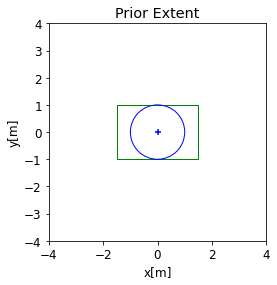

In [8]:
# basis points p with covariance C_p
# state m with covariance C_m
m_init = np.array([0, 0, 0])  # position 0,0 and velocity 0 too
P_init = np.eye(3)
v_init = 10  # note that v > d-1 (!)
V_init = np.eye(2)


# Take a look at the prior
plt.title("Prior Extent")
patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor=c_gt, facecolor='none')
plt.gca().add_patch(patch_ground_truth)
plot_ellipse(m_init, V_init)
plt_square(gt_x[:2], 4)
plt.show()

In [9]:
# Arrays to store intermediate results:
m_list = []
P_list = []
v_list = []
V_list = []

# Initial values:
m = m_init
P = P_init
v = v_init  # start with a circle
V = V_init

for i in range(N_STEPS):
    # get measurements z_i for this step
    W = z_list[i]
    m, P, v, V = predict_rm(m, P, v, V)
    m, P, v, V = update_rm(W, m, P, v, V)  # update with new measurement
    m_list.append(m)
    P_list.append(P)
    v_list.append(v)
    V_list.append(V)

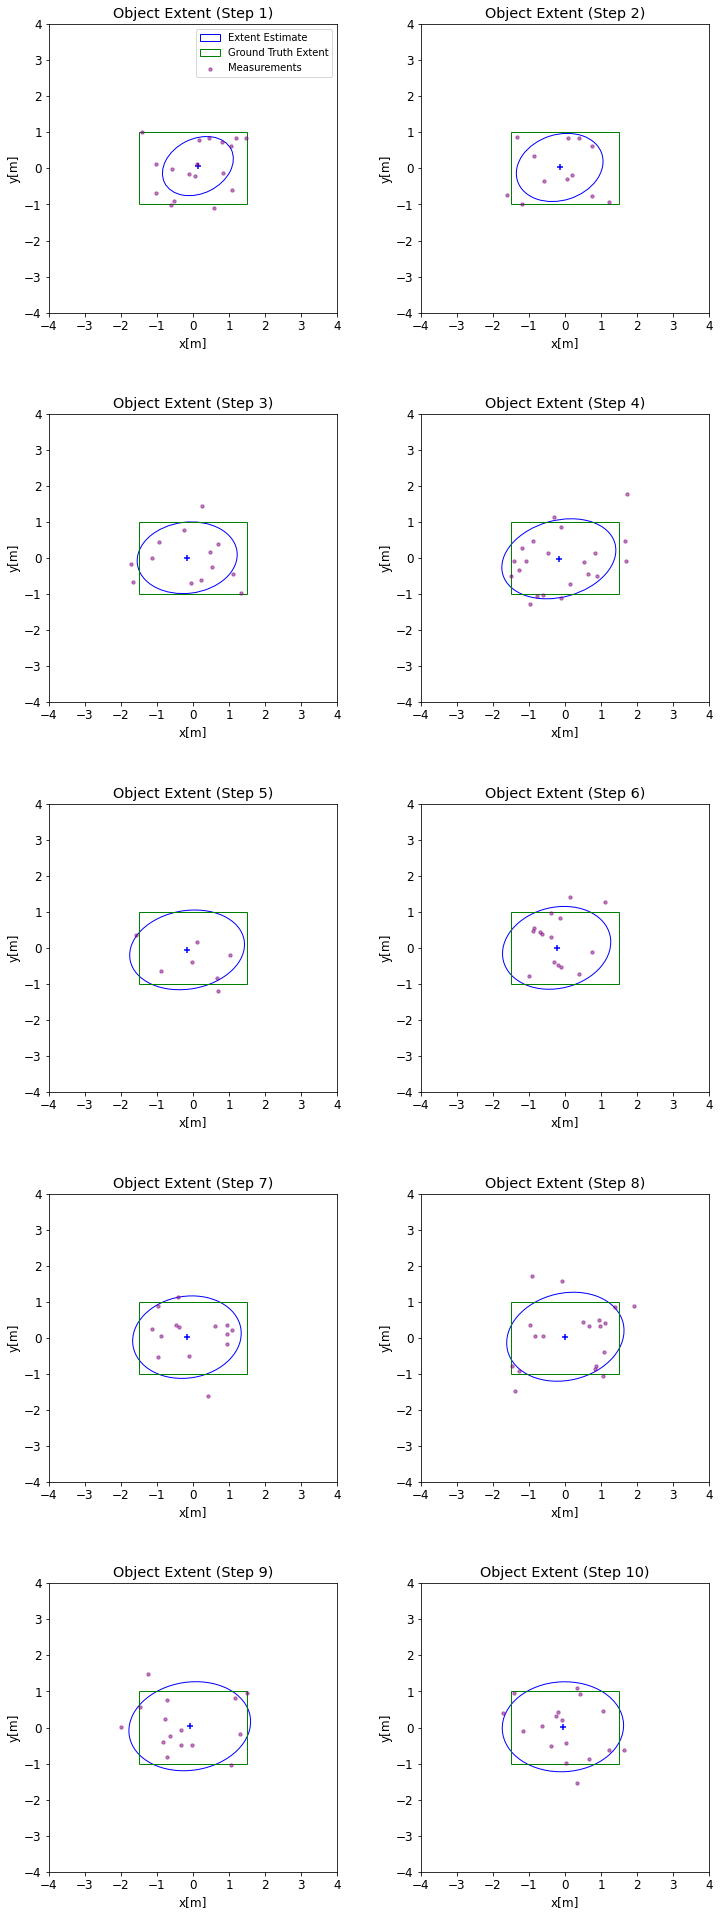

In [10]:
# Visualize each step indivdually:
SIZE = 4  # size parameter for subplots
fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
fig.tight_layout(pad=4.0)
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    # --- EXTENT ESTIMATE:
    plt.sca(ax)
    
    label = "Extent Estimate" if i == 0 else ""  # add a label for the plot corresponding to the first step
    current_X_hat = V_list[i]*(v_list[i]-2*d-2)**-1  # get shape estimate from current step
    plot_ellipse(m_list[i], current_X_hat, label=label)  
    
    # add ground truth:
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor=c_gt, facecolor='none', label="Ground Truth Extent")
    ax.add_patch(patch_ground_truth)
    
    # add measurements 
    ax.scatter(z_list[i][:, 0], z_list[i][:, 1], c=c_meas, label="Measurements", alpha=0.5, s=11)
    # add title and formatting:
    ax.set_title("Object Extent (Step {})".format(i+1))
    plt_square(gt_x[:2], 4)

    if i == 0:
        ax.legend()
plt.show()